# Notebook to visualize graphs

In [78]:
import torch
import networkx as nx
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import Draw
from torch_geometric.utils import to_networkx
from rdkit.Chem import SDMolSupplier
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score



import sys
sys.path.append("../src")

from custom_dataset import QM9ProcessedDataset

In [79]:
dataset = QM9ProcessedDataset(root="../data/QM9Custom")
print(f"Loaded {len(dataset)} molecules")

Loaded 131970 molecules


In [80]:
def convert_mol_to_nx(molecule):
    # Convert to NetworkX graph
    G = to_networkx(molecule, to_undirected=True)

    # Node labels: atomic number → symbol
    atomic_nums = molecule.x[:, 0].tolist()
    atom_labels = [Chem.GetPeriodicTable().GetElementSymbol(int(z)) for z in atomic_nums]
    node_labels = {i: symbol for i, symbol in enumerate(atom_labels)}

    # Node colors: map atomic number to color
    atom_colors = {
        1: "#e6e6e6",   # H - light gray
        6: "#444444",   # C - dark gray
        7: "#4169e1",   # N - blue
        8: "#ff4040",   # O - red
        9: "#00e5e5",   # F - teal
    }
    node_colors = [atom_colors.get(int(z), "#aaaaaa") for z in atomic_nums]


    return G, node_colors, node_labels


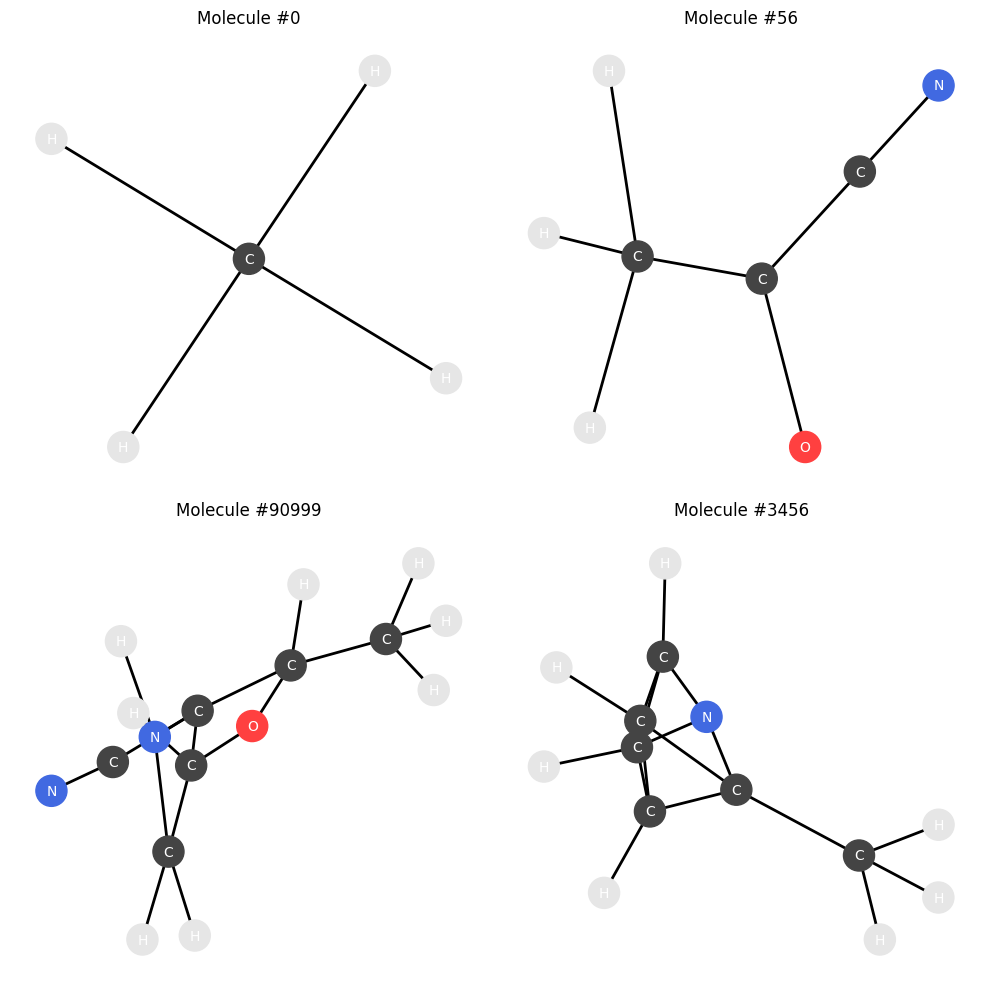

In [81]:
molecule_indices = [0, 56, 90999, 3456]
fig, axes = plt.subplots(2, 2, figsize=(10, 10))

for ax, idx in zip(axes.flatten(), molecule_indices):
    data = dataset[idx]
    G, node_colors, node_labels = convert_mol_to_nx(data)
    pos = nx.spring_layout(G, seed=42)

    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500, ax=ax)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color="white", ax=ax)
    nx.draw_networkx_edges(G, pos, width=2, ax=ax)



    ax.set_title(f"Molecule #{idx}")
    ax.axis("off")

plt.tight_layout()
plt.show()

In [82]:
sdf_path = "../data/QM9/raw/gdb9.sdf"
supplier = SDMolSupplier(sdf_path, removeHs=False)

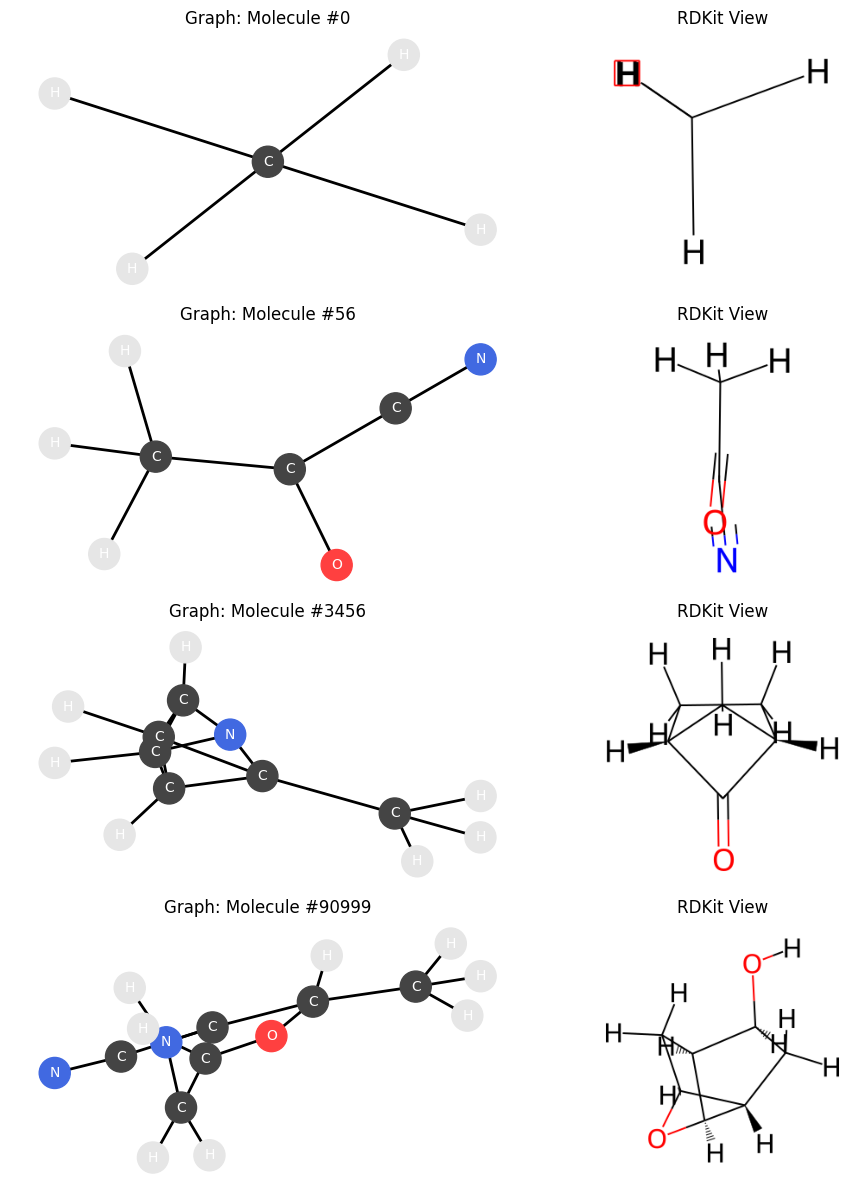

In [ ]:
molecule_indices = [0, 56, 3456, 90999]
n = len(molecule_indices)

fig, axes = plt.subplots(nrows=n, ncols=2, figsize=(10, 3 * n))

for i, idx in enumerate(molecule_indices):
    # Graph side
    data = dataset[idx]
    G, node_colors, node_labels = convert_mol_to_nx(data)
    pos = nx.spring_layout(G, seed=42)

    ax_graph = axes[i, 0]
    nx.draw_networkx_nodes(G, pos, node_color=node_colors, node_size=500, ax=ax_graph)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_color="white", ax=ax_graph)
    nx.draw_networkx_edges(G, pos, width=2, ax=ax_graph)
    ax_graph.set_title(f"Graph: Molecule #{idx}")
    ax_graph.axis("off")

    # RDKit side
    mol = supplier[idx]
    img = Draw.MolToImage(mol, size=(300, 300))

    ax_img = axes[i, 1]
    ax_img.imshow(img)
    ax_img.set_title("RDKit View")
    ax_img.axis("off")

plt.tight_layout()



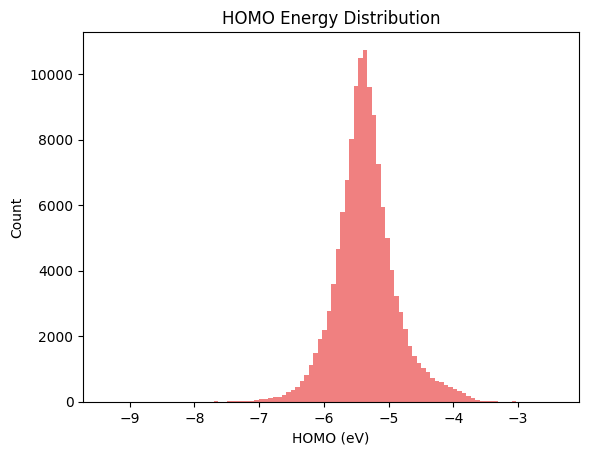

In [84]:
targets = torch.stack([d.y for d in dataset]).numpy().flatten()
plt.hist(targets, bins=100, color='lightcoral')
plt.title("HOMO Energy Distribution")
plt.xlabel("HOMO (eV)")
plt.ylabel("Count")
plt.show()

In [85]:
train_losses = np.load("../results/train_losses.npy")
val_losses = np.load("../results/val_losses.npy")
y_true = np.load("../results/y_true.npy")
y_pred = np.load("../results/y_pred.npy")

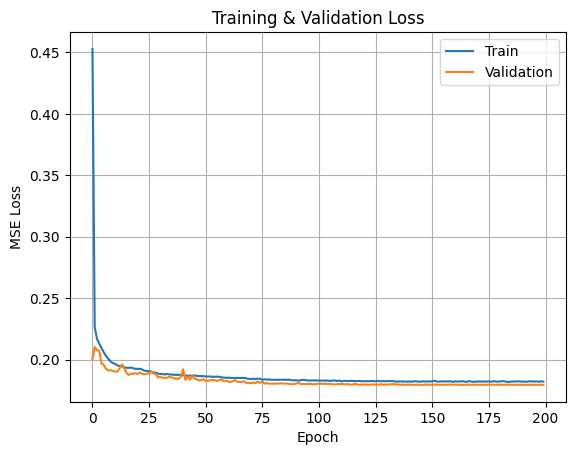

In [92]:
plt.plot(train_losses, label='Train')
plt.plot(val_losses, label='Validation')
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.grid(True)
plt.savefig("./loss_curve.png")

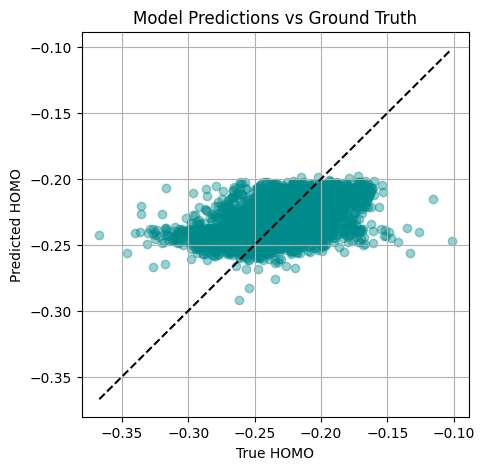

In [93]:
plt.figure(figsize=(5, 5))
plt.scatter(y_true, y_pred, alpha=0.4, color='darkcyan')
plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'k--')
plt.xlabel("True HOMO")
plt.ylabel("Predicted HOMO")
plt.title("Model Predictions vs Ground Truth")
plt.grid(True)
plt.savefig("./pred_vs_true.png")

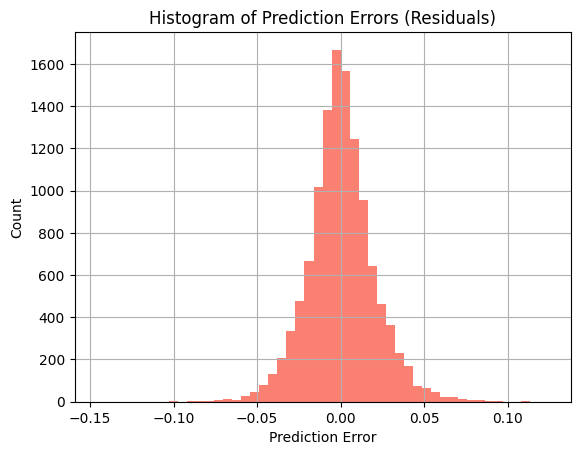

In [88]:
errors = y_pred - y_true
plt.hist(errors, bins=50, color='salmon')
plt.title("Histogram of Prediction Errors (Residuals)")
plt.xlabel("Prediction Error")
plt.ylabel("Count")
plt.grid(True)
plt.show()

In [89]:
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"📉 MSE: {mse:.4f}")
print(f"📊 MAE: {mae:.4f}")
print(f"🔁 R² Score: {r2:.4f}")

📉 MSE: 0.0004
📊 MAE: 0.0148
🔁 R² Score: 0.1789


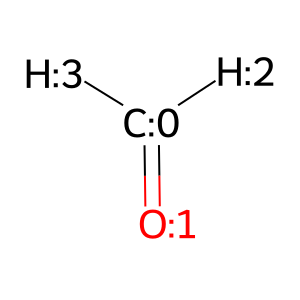

In [95]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import SDMolSupplier

# Load RDKit molecule
sdf_path = "../data/QM9/raw/gdb9.sdf"
supplier = SDMolSupplier(sdf_path, removeHs=False)

mole = supplier[5]  # Match with dataset[0]

# Set atom labels to PyG indices
for i, atom in enumerate(mole.GetAtoms()):
    atom.SetProp("molAtomMapNumber", str(i))

# Draw molecule with atom indices
drawer = rdMolDraw2D.MolDraw2DCairo(300, 300)
drawer.DrawMolecule(mole)
drawer.FinishDrawing()

from IPython.display import Image
Image(data=drawer.GetDrawingText())

In [91]:
data = dataset[5]
print("🔹 Node Feature Matrix (data.x):")
print(data.x)
print(f"Shape: {data.x.shape}  # [num_nodes, num_features]")
num_nodes = data.num_nodes
adj_matrix = torch.zeros((num_nodes, num_nodes))

# Mark edges in the adjacency matrix
for i, j in data.edge_index.t():
    adj_matrix[i, j] = 1

print("🔹 Adjacency Matrix:")
print(adj_matrix)
print("🔹 Edge Feature Matrix (data.edge_attr):")
print(data.edge_attr)
print(f"Shape: {data.edge_attr.shape}  # [num_edges, edge_features]")

🔹 Node Feature Matrix (data.x):
tensor([[6., 0., 3., 0., 0.],
        [8., 0., 1., 0., 0.],
        [1., 0., 1., 0., 0.],
        [1., 0., 1., 0., 0.]])
Shape: torch.Size([4, 5])  # [num_nodes, num_features]
🔹 Adjacency Matrix:
tensor([[0., 1., 1., 1.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [1., 0., 0., 0.]])
🔹 Edge Feature Matrix (data.edge_attr):
tensor([[2., 0., 0.],
        [2., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.],
        [1., 0., 0.]])
Shape: torch.Size([6, 3])  # [num_edges, edge_features]


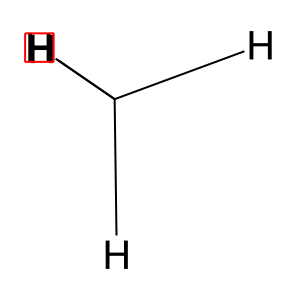

In [ ]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import SDMolSupplier

# Load RDKit molecule
sdf_path = "../data/QM9/raw/gdb9.sdf"
supplier = SDMolSupplier(sdf_path, removeHs=False)

mol = supplier[0]  # Match with dataset[0]
img = Draw.MolToImage(m)

In [ ]:
ololuiiiiiivvvvv